<a href="https://colab.research.google.com/github/Trfitzy/cmi_project/blob/main/DNN_cmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import random
import time
import numpy as np
import polars as pl
#import keras
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from collections import Counter

# Models

- Model: DNN 1 - this was a test to make sure I could get a DNN model running
- Model: DNN 2 - this is the model shown in the image below
- Model: CNN - this was a test to make sure I could get a CNN model running



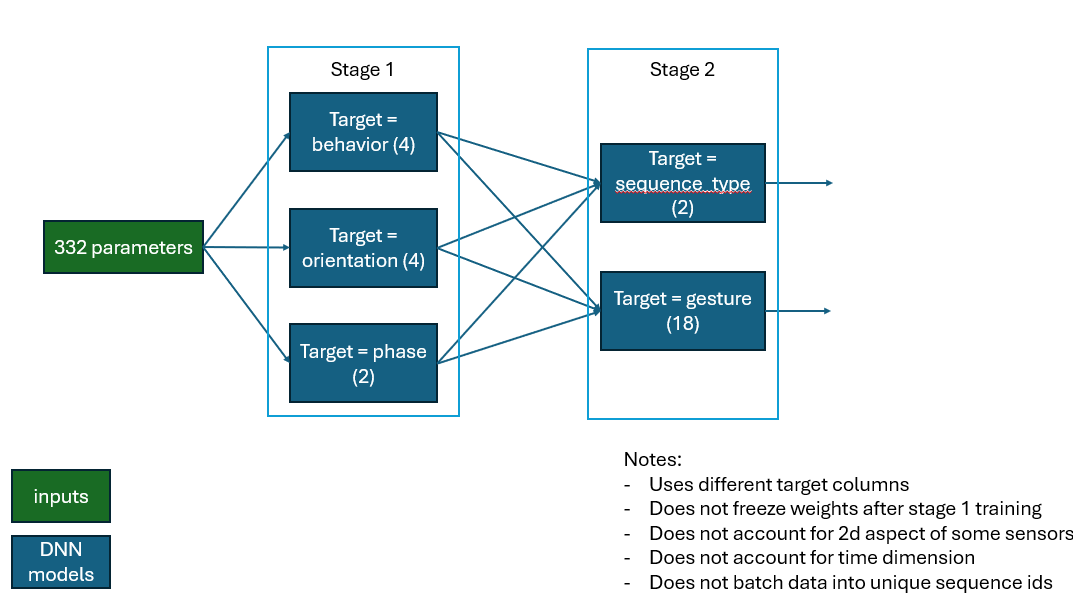

## Functions

In [6]:
class TimeCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        epoch_begin = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print("{time} ---".format(time=epoch_begin),end=(""))

In [7]:
def get_data(filepath):
    data = pl.read_csv(filepath+"train.csv")


    # Split test and train based on unique sequence ids
    random.seed(time.time())
    sequence_ids = list(data['sequence_id'].unique())
    test_num = int(len(sequence_ids)*.2)
    train_ids = []
    test_ids = []
    for seq_id in random.sample(sequence_ids, len(sequence_ids)):
        if len(train_ids) <= test_num:
            train_ids.append(seq_id)
        else:
           test_ids.append(seq_id)

    return train_ids, test_ids, data

In [8]:
def get_data(filepath):
    data = pl.read_csv(filepath+"train.csv")


    # Split test and train based on unique sequence ids
    random.seed(time.time())
    sequence_ids = list(data['sequence_id'].unique())
    test_num = int(len(sequence_ids)*.2)
    train_ids = []
    test_ids = []
    for seq_id in random.sample(sequence_ids, len(sequence_ids)):
        if len(train_ids) <= test_num:
            train_ids.append(seq_id)
        else:
           test_ids.append(seq_id)

    return train_ids, test_ids, data

In [9]:
#----------------------------------------------------------------------------
# Pre-process Data
#----------------------------------------------------------------------------
"""
Preprocessing
X 1. Remove columns that are not numerical or are missing too much data
X 2. Remove outliers by adding floors or ceilings to several columns
X 3. Adjust for skewusing the following methods;
    i. log
    ii. square root
    iii. cube root
    iv. cubed
    v. inverse
4. Normalize with the z-score
XNow all data is between -4 and 4
----------------------------------------------------------------------------
"""
def pre_process(df, target_param, method='zscore') -> pd.DataFrame:
    """
    This function preprocesses the data before it is used in the model.
    Input:  df - (DataFrame) raw data
    Output: df_norm - (DataFrame) processed data

    It should return a data_dic with dfs: X_train, Y_train, X_val, & Y_val. The X dfs should have the train
    features and the Y dfs should have the target_param

    - Normalize training data, and replace needed tof values
    - Repalce target parameter data
    - Split the data 80/20 into train/val
    - Split train and val into X and Y dfs
    - Need to keep sequence_id in all dfs so that we can split by this.
    """

    data_dic = {}
    df[]

    # Normalize (min_max) and replace training data
    train_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
    tof_sensors = []
    for sensor_num in range(1,6):
        for pix_num in range(0,64):
            tof_sensors.append('tof_'+str(sensor_num)+'_v'+str(pix_num)) # sensor_num: 1-5, pix_num:, 0-63



    # Add in sequence id for later use
    # TODO: Should we include the other reference info?
    df_norm['sequence_id'] = df['sequence_id']

    return df_norm

SyntaxError: invalid syntax (ipython-input-9-1514708613.py, line 35)

In [ ]:
def fit_n_assess_model(nmodel, model_info, data):
    print(nmodel.summary())

    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    start = datetime.now()

    # Compile model with MSR as the loss function and SGD as the optimizer
    nmodel.compile(loss=model_info['loss'], optimizer=model_info['optimizer'], metrics=["accuracy"])

    print("Fit model")
    # Fit the model with the training data from the data dictionary.
    nhist1 = nmodel.fit(x = X_train, y = y_train, epochs=model_info['epochs'],
                        callbacks=[TimeCallback()],
                        validation_split=0.2,)

    stop = datetime.now()
    model_info['tdelta'] = str(stop-start)
    print("Runtime: ", str(stop-start))

    print("Evaluate model")
    model_info['test_accuracy'] = str(round(nmodel.evaluate(X_test, y_test, verbose=True)[1],4))
    print("Test accuracy: ",model_info['test_accuracy'])


    plot_model_loss(model_info, nhist1.history, title=nmodel.name)
    print("Loss and accuracy plots saved.")
    return nhist1

In [ ]:
def test_model(nmodel, X_test, y_test):
  # This function gets a prediction for the test data and then finds and prints
  #   the following:
  #     - f1_score
  #     - auc
  #     - roc curve
  #     - precision & recall plots
  # Input:  nmodel - (keras model) trained model
  #         X_test - (array) contains input values for testing the model
  #         y_test - (array) contains true answers for test values
  # Output: None

  # Make predictions on X test data
  y_pred = nmodel.predict(X_test, batch_size=None, steps=None, callbacks=None)

  # Calculate f1 score & auc
  f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='micro')
  auc = np.round(roc_auc_score(y_test, y_pred, multi_class='ovr'), 3)

  print("f1_score for our sample data is {}".format(f1))
  print("Auc for our sample data is {}".format(auc))

  # Modify multi-class y values to a binary class for each multi-class (One Hot Encoding)
  y_onehot_test = LabelBinarizer().fit_transform(y_test)

  # Get plots for the rest of the metrics
  roc_curve(y_onehot_test, y_pred, nmodel.name)
  print("Roc curve plot saved")
  recall_prec_plots(y_onehot_test, y_pred, nmodel.name)
  print("Precision and recall curve plots saved")

#---------------------------------------------------------------------------------------
# Plotting functions
# TODO: need to save to a file instead of showing plots
#------------------------------------------------------------------------------------

def roc_curve(y_onehot_test, y_score, title):
    # This function creates the roc curve
    # Input:  y_onehot_test - (array) contains true answers for test values, one hot encoded
    #         y_score - (array) contains predicted probabilities for answers to test values
    # Output: None
    fig, ax = plt.subplots(figsize=(6, 6))

    for class_id in range(10):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id}",
            ax=ax,
            plot_chance_level=(class_id == 9),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="MNIST classification\nto One-vs-Rest multiclass",
    )

    filename = title+"_roc_curve.png"
    plt.savefig("./plots/"+filename)
    plt.clf()

def recall_prec_plots(y_test, y_score, title):
    # This function creates the recall-precision curves
    # Input:  y_onehot_test - (array) contains true answers for test values, one hot encoded
    #         y_score - (array) contains predicted probabilities for answers to test values
    # Output: None

    # For each class
    precision = dict()
    recall = dict()
    threshold = dict()
    average_precision = dict()

    for i in range(10):
        precision[i], recall[i], threshold[i] = precision_recall_curve(y_test[:,i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:,i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], threshold['micro'] = precision_recall_curve(
        y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
        prevalence_pos_label=Counter(y_test.ravel())[1] / y_test.size,
    )
    display.plot(plot_chance_level=True)

    filename = title+"_avg_precision.png"
    plt.savefig("./plots/"+filename)
    plt.clf()

    _ = display.ax_.set_title("Micro-averaged over all classes")

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(10):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Extension of Precision-Recall curve to multi-class")

    filename = title+"_precision_recall_curve"
    plt.savefig("./plots/"+filename)
    plt.clf()
    #plt.show()
    #return precision, recall, threshold, average_precision

def plot_model_loss(model_info, hist, title="model loss"):
    # This function creates the train & validation loss comparison plots and saves them to a file
    #
    # Output: None

    train_loss = hist['loss']
    val_loss = hist['val_loss']
    train_acc = hist['accuracy']
    val_acc = hist['val_accuracy']

    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(2,1,1)

    ax1.plot(range(0,model_info['epochs']),train_loss, label="training set")
    ax1.plot(range(0,model_info['epochs']),val_loss, label="validation set")
    ax1.set_ylabel(model_info['loss'].name)
    ax1.legend(loc="upper right")

    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(range(0,model_info['epochs']), train_acc, label="training set")
    ax2.plot(range(0,model_info['epochs']), val_acc, label="validation set")
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc="upper right")
    ax2.set_ylabel('Epoch')

    plot_title = title+" \n("
    cnt = 0
    for key, value in model_info.items():
      if key != 'loss':
        if key == "optimizer":
          if type(value) != str:
            value = value.name
        plot_title += key + ": "+ str(value) + ", "
        cnt += 1
        if cnt == 4:
          plot_title += "\n"
          cnt = 0
    plot_title += ")"

    fig.suptitle(plot_title, y=1.02, fontsize=12)
    plt.tight_layout()
    #plt.show()

    filename = title+"_loss_accuracy.png"
    fig.savefig("./plots/"+filename, bbox_inches='tight')
    plt.clf()

def vis_output(inputs, outputs, image, title):
    # redefine mode to output right after the first hidden layer
    nLayer = keras.Model(inputs = inputs, outputs = outputs)
    #nLayer.summary()

    # get feature map for 1st layer
    feature_maps = nLayer.predict(image)

    out_size = feature_maps.shape[-1]
    if round(out_size/4) != (out_size/4):
        print("Size not div by 4: ",out_size)
    elif len(feature_maps.shape) < 4:
        print("Feature map too small for images: ",feature_maps.shape)
    else:

        # plot maps
        for n in range(out_size):
            ax = plt.subplot(int(out_size/4), 4, n+1)
            plt.imshow(feature_maps[0, :, :, n], cmap='gray')
        #plt.show()

def all_vis_output(nmodel, image, title, n_layers='all'):

    if n_layers == "all":
       n_layers = len(nmodel.layers)

    filename = title+"_image.png"
    plt.imsave("./plots/"+filename, image, cmap='gray')
    #plt.show()
    plt.clf()

    for n in range(n_layers):
        vis_output(nmodel.inputs, nmodel.layers[n].output, np.expand_dims(image, axis=0), title)

# Main

In [10]:

# Main
## Pull in & Preprocess Data
filepath = "C:/Users/trfit/OneDrive/Documents/learning/UC/cmi_project/cmi-detect-behavior-with-sensor-data/"
filepath = "/content/"


train_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
#train_features = []
for sensor_num in range(1,6): # sensor_num: 1-5, pix_num:, 0-63
        for pix_num in range(0,64):
            train_features.append('tof_'+str(sensor_num)+'_v'+str(pix_num))

print("Inital parameters defined. Start pulling data...")

train_ids, test_ids, data = get_data(filepath)

print("Data pulled. Start data cleaning...")

# Remove null values
data = data.drop_nulls()

# Normalize data
train_features_norm = []
for feature in train_features:
    train_features_norm.append(feature+"_norm")
    if 'tof_' in feature:
        data = data.with_columns(pl.col(feature).replace(-1, 256))
        data = data.with_columns((pl.col(feature)/253).alias(feature+"_norm"))
    else:
        data = data.with_columns(
            ((pl.col(feature)-pl.col(feature).min())/
             (pl.col(feature).max()-pl.col(feature).min())
            ).alias(feature+"_norm"))

print("Data cleaned.")



Inital parameters defined. Start pulling data...
Data pulled. Start data cleaning...
Data cleaned.


## Model: DNN_1




Notes:
- DNN w/ sequence_type as target:
  Fit model

 - 2025-07-07 17:00:41 ---Epoch 1/5
 - 584/584 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5886 - loss: 0.- 8050 - val_accuracy: 0.6452 - val_loss: 0.6265
 2025-07-07 17:00:47 ---Epoch 2/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6734 - loss: 0.5523 - val_accuracy: 0.6272 - val_loss: 0.6298
2025-07-07 17:00:50 ---Epoch 3/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7122 - loss: 0.5197 - val_accuracy: 0.6495 - val_loss: 0.6019
2025-07-07 17:00:57 ---Epoch 4/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7248 - loss: 0.4966 - val_accuracy: 0.6290 - val_loss: 0.6414
2025-07-07 17:01:00 ---Epoch 5/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7357 - loss: 0.4844 - val_accuracy: 0.6397 - val_loss: 0.6688
Runtime:  0:00:22.304905
Evaluate model
2888/2888 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6512 - loss: 0.6095

  - Test accuracy:  0.6682

In [59]:
target_param = 'sequence_type'

# Prep target data
target_uniq = data[target_param].unique()
data = data.with_columns(target=pl.col(target_param).replace(target_uniq, [x for x in range(len(target_uniq))]).cast(pl.Int8))

# Create train and test dataframes
X_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select(train_features_norm))
y_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select('target'))
X_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select(train_features_norm))
y_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select('target'))

data_dic = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}


In [44]:
## Model
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model_info["optimizer"] = keras.optimizers.Adam(learning_rate=model_info['learning_rate'])

model = keras.Sequential(
            [
                keras.Input(shape=(320,)),
               # keras.layers.Flatten(),
               # keras.layers.Dense(512, activation=model_info['activation']),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                #keras.layers.Dense(10, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi'
            )

In [45]:
#fit_n_assess_model(nmodel, model_info, data):
nmodel = model
#data = data_dic
print(nmodel.summary())

X_train = np.asarray(data_dic['X_train'])
y_train = np.asarray(data_dic['y_train'])
X_test = np.asarray(data_dic['X_test'])
y_test = np.asarray(data_dic['y_test'])

start = datetime.now()

# Compile model with MSR as the loss function and SGD as the optimizer
nmodel.compile(loss=model_info['loss'], optimizer=model_info['optimizer'], metrics=["accuracy"])

print("Fit model")
# Fit the model with the training data from the data dictionary.
nhist1 = nmodel.fit(x = X_train, y = y_train, epochs=model_info['epochs'],
                    callbacks=[TimeCallback()],
                    validation_split=0.2,)

stop = datetime.now()
model_info['tdelta'] = str(stop-start)
print("Runtime: ", str(stop-start))

print("Evaluate model")
model_info['test_accuracy'] = str(round(nmodel.evaluate(X_test, y_test, verbose=True)[1],4))
print("Test accuracy: ",model_info['test_accuracy'])


#plot_model_loss(model_info, nhist1.history, title=nmodel.name)
#print("Loss and accuracy plots saved.")


Model: "DNN-cmi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,200 (465.62 KB)

 Trainable params: 119,200 (465.62 KB)

 Non-trainable params: 0 (0.00 B)

None
Fit model
2025-07-08 15:34:17 ---Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4626 - loss: 2.1543 - val_accuracy: 0.1512 - val_loss: 1.0986
2025-07-08 15:34:19 ---Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5312 - loss: 0.9141 - val_accuracy: 0.1512 - val_loss: 0.6931
2025-07-08 15:34:20 ---Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5308 - loss: 0.6931 - val_accuracy: 0.1512 - val_loss: 0.6931
2025-07-08 15:34:20 ---Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5613 - loss: 0.6931 - val_accuracy: 0.1512 - val_loss: 0.6931
2025-07-08 15:34:20 ---Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5174 - loss: 0.6931 - val_accuracy: 0.1512 - val_loss: 0.6931
Runtime:  0:00:02.671538
Evaluate model
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7520 - loss: 0.6931
Test accuracy:  0.7641


## Model: DNN 2

four DNN models that come together
- focuses on orientation: 4 ['Seated Lean Non Dom - FACE DOWN', 'Lie on Side - on Dominant', 'Seated Straight', 'Lie on Back']
- focuses on behavior: 4 ['Relaxes and moves hand to target location', 'Hand at target location', 'Performs gesture', 'Moves hand to target location']
- focuses on phase: 2 ['Transition', 'Gesture']

---------------------------------------------
- sequence_type: 2 ['Target', 'Non-Target']
-gesture: 18
['Cheek - pinch skin', 'Forehead - pull hairline',
       'Write name on leg', 'Feel around in tray and pull out an object',
       'Neck - scratch', 'Neck - pinch skin', 'Eyelash - pull hair',
       'Eyebrow - pull hair', 'Forehead - scratch',
       'Above ear - pull hair', 'Wave hello', 'Write name in air',
       'Text on phone', 'Pull air toward your face',
       'Pinch knee/leg skin', 'Scratch knee/leg skin',
       'Drink from bottle/cup', 'Glasses on/off']



In [14]:
## Model
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model_info["optimizer"] = keras.optimizers.Adam(learning_rate=model_info['learning_rate'])

model_o = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-orientation'
            )

model_b = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-behavior'
            )

model_p = keras.Sequential(
            [
                keras.Input(shape=(332,)),
                keras.layers.Dense(256, activation=model_info['activation']),
                keras.layers.Dense(128, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-phase'
            )


models = {
    '_o': model_o,
    '_b': model_b,
    '_p': model_p,
}

for model in models.values():
  print(model.summary())

Model: "DNN-cmi-orientation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,404 (478.14 KB)

 Trainable params: 122,404 (478.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "DNN-cmi-behavior"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,404 (478.14 KB)

 Trainable params: 122,404 (478.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "DNN-cmi-phase"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,338 (477.88 KB)

 Trainable params: 122,338 (477.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
X_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select(train_features_norm))
X_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select(train_features_norm))

data_dic = {
      'X_train': np.asarray(X_train),
      #'y_train'+suffix: y_train,
      'X_test': np.asarray(X_test),
     # 'y_test'+suffix: y_test
  }

target_params = {'_o': 'orientation',
                 '_b': 'behavior',
                 '_p': 'phase',
                 '_g': 'gesture',
                 '_s': 'sequence_type'}

for suffix, target_param in target_params.items():

  # Prep target data
  target_uniq = data[target_param].unique()
  data = data.with_columns(target=pl.col(target_param).replace(target_uniq, [x for x in range(len(target_uniq))]).cast(pl.Int8))

  # Create train and test dataframes

  y_train = (data.filter(pl.col("sequence_id").is_in(train_ids)).select('target'))

  y_test = (data.filter(pl.col("sequence_id").is_in(test_ids)).select('target'))

  data_dic['y_train'+suffix] = np.asarray(y_train)
  data_dic['y_test'+suffix] = np.asarray(y_test)


In [15]:
# Compile & Fit Stage 1 models
hist = {}

for suffix in ["_o", "_b", "_p"]:
  start = datetime.now()

  print(type(data_dic['X_train']))
  print(type(data_dic['y_train'+suffix]))

  models[suffix].compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
  hist[suffix] = models[suffix].fit(
      x = data_dic['X_train'],
      y = data_dic['y_train'+suffix],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

  stop = datetime.now()
  #model_info['tdelta'] = str(stop-start)
  print("model"+suffix+" Runtime: ", str(stop-start))



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2025-07-09 00:32:31 ---Epoch 1/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5120 - loss: 1.1127 - val_accuracy: 0.7347 - val_loss: 0.7285
2025-07-09 00:32:49 ---Epoch 2/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8010 - loss: 0.5240 - val_accuracy: 0.8257 - val_loss: 0.5170
2025-07-09 00:33:03 ---Epoch 3/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8684 - loss: 0.3592 - val_accuracy: 0.8336 - val_loss: 0.4959
2025-07-09 00:33:18 ---Epoch 4/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8959 - loss: 0.2847 - val_accuracy: 0.8569 - val_loss: 0.4494
2025-07-09 00:33:33 ---Epoch 5/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9124 - loss: 0.2452 - val_accuracy: 0.8772 - val_loss: 0.4256
model_o Runtime:  0:01:24.095099
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2025-07-09 00:33:55 ---Epoch 1/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5709 - loss: 1.

In [ ]:
# Build, Compile, & Fit Stage 2 models
# for layer in model1.layers:
#    layer.trainable = False

model_s = keras.Sequential(
            [
                keras.Input(shape=(10,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(64, activation=model_info['activation']),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'DNN-cmi-sequence'
            )

inp       = keras.Input(shape=(332,)),   # or whatever raw shape you need
out_o      = models["_o"](inp)                    # <-- CALL; now outA is a tensor
out_b      = models["_b"](inp)
out_p      = models["_p"](inp)

merged    = keras.layers.Concatenate()([out_o, out_b, out_p])
#x         = keras.layers.Dense(128, activation="relu")(merged)
#final_out = keras.layers.Dense(num_classes, activation="softmax")(x)

#combo     = keras.Model(inp, final_out)
#merged = keras.layers.Concatenate(axis=-1)([models["_o"].output, models["_b"].output, models["_p"].output]),
x = keras.layers.Dense(32, activation="relu")(merged)
#x = keras.layers.Dropout(0.3)(x)
final_out_g = keras.layers.Dense(18, activation="softmax")(x)
final_out_s = keras.layers.Dense(2, activation="softmax")(x)

model_g = keras.Model(inputs = inp, outputs=final_out_g)
print(model_g.summary())

start = datetime.now()
model_g.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_g = model_g.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_g'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_g Runtime: ", str(stop-start))

model_s = keras.Model(inputs = inp, outputs=final_out_s)
print(model_s.summary())

start = datetime.now()
model_s.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
                         metrics=["accuracy"])
hist_s = model_s.fit(
      x = data_dic['X_train'],
      y = data_dic['y_train_s'],
      epochs=model_info['epochs'],
      callbacks=[TimeCallback()],
      validation_split=0.2,
      )

stop = datetime.now()
#model_info['tdelta'] = str(stop-start)
print("model_s Runtime: ", str(stop-start))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-orientation │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-behavior    │ (None, 4)         │    122,404 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN-cmi-phase       │ (None, 2)         │    122,338 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ DNN-cmi-orientat… │
│ (Concatenate)       │                   │            │ DNN-cmi-behavior… │
│                     │                   │            │ DNN-cmi-phase[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │        352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 18)        │        594 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 368,092 (1.40 MB)

 Trainable params: 368,092 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

None
2025-07-09 00:37:34 ---Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ('keras_tensor_26',)
Received: inputs=Tensor(shape=(32, 332))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 332))',)
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_5
Received: inputs=('Tensor(shape=(32, 332))',)
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_10
Received: inputs=('Tensor(shape=(32, 332))',)
  warnings.warn(msg)


2638/2639 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2003 - loss: 2.5285

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ('keras_tensor_26',)
Received: inputs=Tensor(shape=(None, 332))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 332))',)
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_5
Received: inputs=('Tensor(shape=(None, 332))',)
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_10
Received: inputs=('Tensor(shape=(None, 332))',)
  warnings.warn(msg)


2639/2639 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.2003 - loss: 2.5284 - val_accuracy: 0.2544 - val_loss: 2.2824
2025-07-09 00:38:06 ---Epoch 2/5
2639/2639 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3270 - loss: 2.0342 - val_accuracy: 0.3151 - val_loss: 2.1882
2025-07-09 00:38:33 ---Epoch 3/5
1830/2639 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3890 - loss: 1.8312

## Model: CNN

In [30]:
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

model = keras.Sequential(
    [
        # Block 1
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(10, kernel_size=(1, 1), activation=model_info['activation']),
        #keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        keras.layers.Conv2D(20, kernel_size=(1, 1), activation=model_info['activation']),
        #keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(10, activation=model_info['final_activation']),
    ],
    name = 'CNN-cmi'
    )
model.summary()

Model: "CNN-cmi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 20)       │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,090 (51.13 KB)

 Trainable params: 13,090 (51.13 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
data_dic['X_train'] = X_train.to_numpy().reshape(-1, 8, 8, 5) # 5 sensors with 8x8 dist grid
data_dic['X_test'] = X_test.to_numpy().reshape(-1, 8, 8,5) # 5 sensors with 8x8 dist grid




In [34]:
#fit_n_assess_model(nmodel, model_info, data):
nmodel = model
#data = data_dic
print(nmodel.summary())

X_train = np.asarray(data_dic['X_train'])
y_train = np.asarray(data_dic['y_train_s'])
X_test = np.asarray(data_dic['X_test'])
y_test = np.asarray(data_dic['y_test_s'])

start = datetime.now()

# TODO: !!!!! DONT REUSE OPTIMIZER !!!!

# Compile model with MSR as the loss function and SGD as the optimizer
nmodel.compile(loss=model_info['loss'], optimizer="adam",#model_info['optimizer'],
               metrics=["accuracy"])

print("Fit model")
# Fit the model with the training data from the data dictionary.
nhist1 = nmodel.fit(x = X_train, y = y_train, epochs=model_info['epochs'],
                    callbacks=[TimeCallback()],
                    validation_split=0.2,)

stop = datetime.now()
model_info['tdelta'] = str(stop-start)
print("Runtime: ", str(stop-start))

print("Evaluate model")
model_info['test_accuracy'] = str(round(nmodel.evaluate(X_test, y_test, verbose=True)[1],4))
print("Test accuracy: ",model_info['test_accuracy'])


#plot_model_loss(model_info, nhist1.history, title=nmodel.name)
#print("Loss and accuracy plots saved.")

Model: "CNN-cmi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 20)       │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,090 (51.13 KB)

 Trainable params: 13,090 (51.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Fit model
2025-07-08 23:45:47 ---Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5907 - loss: 1.1386 - val_accuracy: 1.0000 - val_loss: 0.2348
2025-07-08 23:45:50 ---Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7531 - loss: 0.6013 - val_accuracy: 0.9864 - val_loss: 0.3595
2025-07-08 23:45:50 ---Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7700 - loss: 0.5330 - val_accuracy: 0.9932 - val_loss: 0.2960
2025-07-08 23:45:50 ---Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7810 - loss: 0.4525 - val_accuracy: 0.9932 - val_loss: 0.2339
2025-07-08 23:45:51 ---Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7905 - loss: 0.4114 - val_accuracy: 0.9898 - val_loss: 0.2412
Runtime:  0:00:04.671936
Evaluate model
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6414 - loss: 0.6599
Test accuracy:  0.5832


In [77]:
print("TensorFlow", tf.__version__)
print("Eager mode?", tf.executing_eagerly())
tensor = tf.constant([1,2,3])
print(tensor.numpy())

TensorFlow 2.18.0
Eager mode? True
[1 2 3]


In [74]:
X_train = X_train.astype("float32", copy=False)
y_train = y_train.astype("float32", copy=False)

history = nmodel.fit(
    X_train,
    y_train,
    epochs=model_info["epochs"],
    validation_split=0.20,
    callbacks=[TimeCallback()],
)

2025-07-08 15:56:34 ---Epoch 1/5


NotImplementedError: numpy() is only available when eager execution is enabled.

In [4]:
from tensorflow import keras

cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(8, (1,1),activation='relu', input_shape=(8, 8, 5)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model. Summary()

AttributeError: 'Sequential' object has no attribute 'Summary'

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model. Summary()

AttributeError: 'Sequential' object has no attribute 'Summary'

## Evaluation:
- F1 score

In [ ]:
from sklearn.metrics import f1_score

binary_arr = y_test["target"].gt(0.5).to_numpy()
y_pred_bin = (lr_model.predict(data_dic['X_test']) >= 0.5)

# Compute binary F1 (Target vs Non-Target)
# y_true_bin = sol['gesture'].isin(self.target_gestures).values
# y_pred_bin = sub['gesture'].isin(self.target_gestures).values
f1_binary = f1_score(
    binary_arr,
    y_pred_bin,
    pos_label=1,
    zero_division=0,
    average='binary'
)
print(f1_binary)